In [ ]:
## Importando as bibliotecas
from torch.utils.data import Dataset, DataLoader
import torch
import torch.nn as nn
import torchvision.models as models
from torchvision import transforms
import torch.optim as optim
from torchvision.datasets import CIFAR10
from torch.optim import lr_scheduler
from PIL import Image
import cv2
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt
import random
from google.colab.patches import cv2_imshow

#import mlflow

In [ ]:
class ChangeBackground():
    def __init__(self, path_background):
         background_names = os.listdir(path_background)
         self.background_list = []

         for background in background_names:
           background_path = os.path.join(path_background, background)
           self.background_list.append(background_path)


         self.num_imgs = len(self.background_list)

         #print("Qtd de fotos de background: ", self.num_imgs)
         #print(self.background_list)

         self.lower_green = (30, 70, 70)
         self.upper_green = (90, 255, 255)



    def __call__(self, img):

        number = random.randint(0, self.num_imgs)

        #print("Numero aleatorio: ", number)

        img = np.array(img)
        #img = cv2.resize(img, (350,300))

        if number != self.num_imgs:
          hsv = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)

          green_background = cv2.inRange(hsv, self.lower_green, self.upper_green)
          not_green = cv2.bitwise_not(green_background)

          bg = cv2.imread(self.background_list[number])
          bg = cv2.resize(bg, (img.shape[1], img.shape[0]))

          result = cv2.bitwise_and(img, img, mask = not_green)
          result2 = cv2.bitwise_or(result, bg, mask = green_background)
          changed_image = cv2.add(result, result2)


          changed_image = cv2.cvtColor(changed_image, cv2.COLOR_BGR2RGB)
          changed_image = Image.fromarray(changed_image)

          return changed_image
        else:

          img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
          img = Image.fromarray(img)

          return img

In [ ]:
label_to_index = {3: 0, 4: 1, 5: 2, 6: 3, 7: 4}

Primeiro, bora dar uma olhada nos nossos conjuntos de dados para treino e teste.

Lembrando que, estamos usando 75% para treino e 25% para teste.

In [ ]:
data_csv = '/content/drive/MyDrive/Water Level Identification/Pool/classification/pool_all_samples_balaceados.csv'

df = pd.read_csv(data_csv)


labels = df['label'].unique().tolist()

print(labels)

count = df['label'].value_counts()

print(count)

[3, 4, 5, 6, 7]
3    26
4    26
5    26
6    26
7    26
Name: label, dtype: int64


In [ ]:
from sklearn.model_selection import train_test_split

classes = df['label'].unique()
num_classes = len(classes)

print('Classes: ', classes)
print('Num de classes: ',num_classes)

X_train, X_test, y_train, y_test = train_test_split(df['id'], df['label'], test_size=0.15, stratify=df['label'])

print("Tamanho conjunto de treino: ", len(X_train))
print("Tamanho conjunto de teste: ", len(X_test))

n_train_per_class = max(1, int(len(X_train) / num_classes))
n_test_per_class = max(1, int(len(X_test) / num_classes))

print(X_test.tolist())
print(y_test.tolist())

def create_csv_from_list(images, labels, mode):
  data = {'id': images, 'label': labels}

  df = pd.DataFrame(data)

  print(mode)
  print(df)

  df.to_csv( str(mode) + '-PISCINA.csv' , index = False)


create_csv_from_list(X_test, y_test, 'test')
create_csv_from_list(X_train, y_train, 'train')

Classes:  [3 4 5 6 7]
Num de classes:  5
Tamanho conjunto de treino:  110
Tamanho conjunto de teste:  20
['1657231316671.jpg', '1657231315955.jpg', 'IMG_20220702_112500.jpg', '1657231316004.jpg', '1657231316277.jpg', '1657231316986.jpg', '1657231316395.jpg', '1657231316039.jpg', '1657231316254.jpg', '1657231315817.jpg', '1657231315874.jpg', '1657231315834.jpg', '1657231316655.jpg', '1657231316663.jpg', '1657231316192.jpg', '1657231315667.jpg', '1657231315972.jpg', '1657173216923.jpg', '1657231316521.jpg', '1657231316056.jpg']
[6, 3, 7, 3, 4, 6, 4, 5, 4, 7, 7, 7, 6, 6, 4, 5, 3, 5, 5, 3]
test
                          id  label
80         1657231316671.jpg      6
5          1657231315955.jpg      3
129  IMG_20220702_112500.jpg      7
11         1657231316004.jpg      3
38         1657231316277.jpg      4
98         1657231316986.jpg      6
47         1657231316395.jpg      4
54         1657231316039.jpg      5
35         1657231316254.jpg      4
114        1657231315817.jpg      7
118   

In [ ]:
def plot_label_quantidade(csv_file):
    df = pd.read_csv(csv_file)

    label_counts = df['label'].value_counts()

    plt.figure(figsize=(10, 6))
    label_counts.plot(kind='bar')
    plt.xlabel('Label')
    plt.ylabel('Quantidade')
    plt.title('Rótulo por Quantidade')
    plt.xticks(rotation=0)
    plt.show()

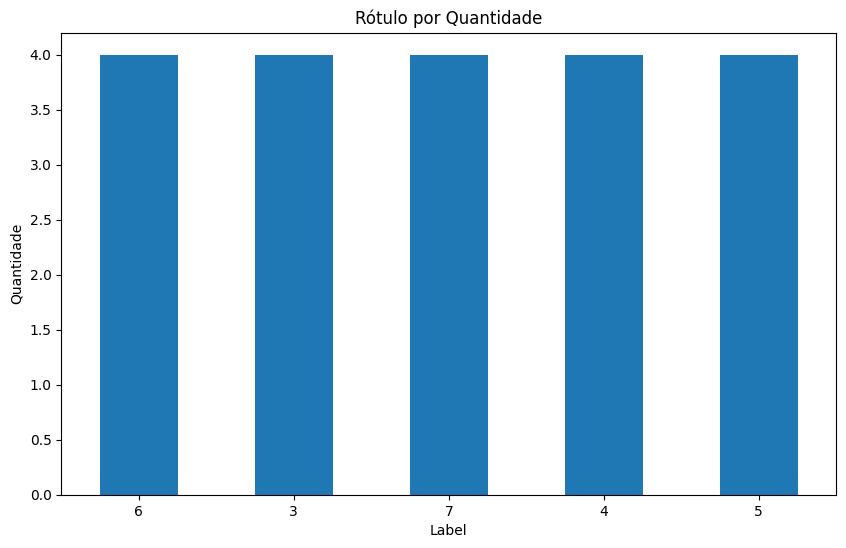

In [ ]:
plot_label_quantidade('/content/test-PISCINA.csv')

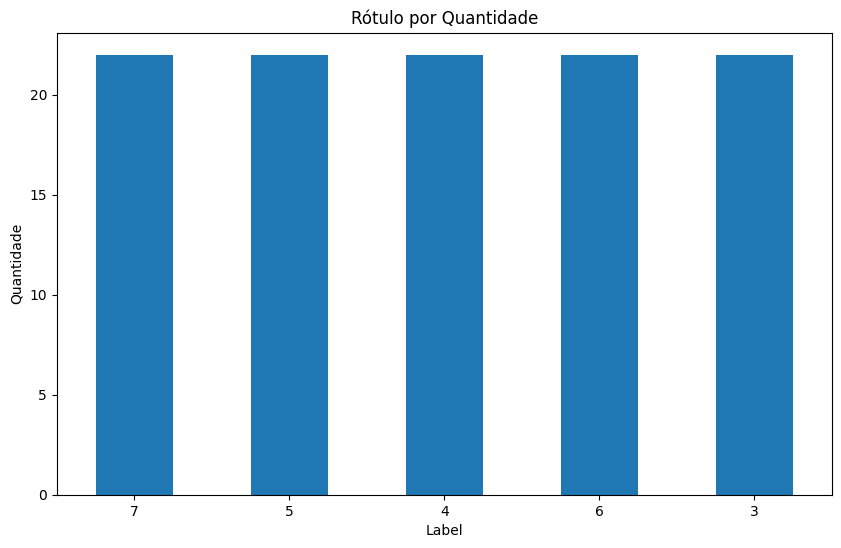

In [ ]:
plot_label_quantidade('/content/train-PISCINA.csv')

Agora, vamos criar nossos datasets de treino e teste e visualizar alguns samples

In [ ]:
## Criando a função custom de datasets do pytorch.
class WaterLevelDataset(Dataset):
    def __init__(self, csv_file, images_root, label_to_index, transform=None):
        self.data = pd.read_csv(csv_file)
        self.images_root = images_root
        self.transform = transform
        self.label_to_index = label_to_index

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        image_path = os.path.join(self.images_root, self.data.iloc[idx, 0])

        image = Image.open(image_path)

        label = self.data.iloc[idx, 1]
        label = self.label_to_index[label]  # Substitua o rótulo pelo número inteiro correspondente

        if self.transform:
            image = self.transform(image)

        return image, label

In [ ]:
train_transform = transforms.Compose([
    transforms.Resize(456),
    #ChangeBackground('/content/drive/MyDrive/Water Level Identification/Backgrounds'),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(degrees=(10)),
    transforms.ToTensor(),
    #transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
])


test_transform = transforms.Compose([
    transforms.Resize(456),
    #ChangeBackground('/content/drive/MyDrive/Water Level Identification/Backgrounds'),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(degrees=(10)),
    transforms.ToTensor(),
    #transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
])


images_root = '/content/drive/MyDrive/Water Level Identification/Pool/Images Pool'

train_dataset = WaterLevelDataset('/content/train-PISCINA.csv', images_root, label_to_index, transform = train_transform)
train_dataloader = DataLoader(train_dataset, batch_size=8, shuffle=True, pin_memory=True)


test_dataset = WaterLevelDataset('/content/test-PISCINA.csv', images_root, label_to_index, transform = test_transform)
test_dataloader = DataLoader(test_dataset, batch_size=8, shuffle=True, pin_memory=True)

In [ ]:
# for i, (images, labels) in enumerate(train_dataloader):
#     if i < 1:
#         plt.figure(figsize=(10, 5))
#         for j in range(images.shape[0]):
#             plt.subplot(1, images.shape[0], j + 1)
#             plt.imshow(images[j].permute(1, 2, 0))
#             plt.title(f"Label: {labels[j]+3}")
#             plt.axis('off')
#         plt.show()

In [ ]:
# for i, (images, labels) in enumerate(test_dataloader):
#     if i < 1:
#         plt.figure(figsize=(10, 5))
#         for j in range(images.shape[0]):
#             plt.subplot(1, images.shape[0], j + 1)
#             plt.imshow(images[j].permute(1, 2, 0))
#             plt.title(f"Label: {labels[j]+3}")
#             plt.axis('off')
#         plt.show()

In [ ]:
num_epochs = 70
learning_rate = 0.001

In [ ]:
# model = models.resnet18(pretrained=True)
# num_classes = 5

# # Congele as camadas da ResNet
# for param in model.parameters():
#     param.requires_grad = False

# # Substitua a camada final (classificadora)
# model.fc = nn.Linear(model.fc.in_features, num_classes)

In [ ]:
from torchvision.models import efficientnet_b4, EfficientNet_B4_Weights
from torchvision.models._api import WeightsEnum
from torch.hub import load_state_dict_from_url

def get_state_dict(self, *args, **kwargs):
    kwargs.pop("check_hash")
    return load_state_dict_from_url(self.url, *args, **kwargs)
WeightsEnum.get_state_dict = get_state_dict

model = efficientnet_b4(weights=EfficientNet_B4_Weights.IMAGENET1K_V1)

num_classes = 5

for params in model.parameters():
  params.requires_grad = False

model.classifier[1] = nn.Linear(in_features=1792, out_features=num_classes)

print(model)


EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 48, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(48, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): MBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(48, 48, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=48, bias=False)
            (1): BatchNorm2d(48, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(48, 12, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(12, 48, kernel_size=(1, 1), stride=(1, 1))
            (activation): SiLU(inplace=True)
            (scale_activation): Sigmoid()
          )
          (2): Conv2dNormActiv

In [ ]:
from torch.nn.modules.loss import CrossEntropyLoss

criterion = CrossEntropyLoss(label_smoothing = 0.1)


optimizer = optim.Adam(model.parameters(), lr = learning_rate)


scheduler = lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model.to(device)

In [ ]:
def train(model, train_loader, optimizer, criterion, device):
    model.train()
    total_loss = 0.0
    correct = 0
    total = 0

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        ##Trecho que add o mixup
        #inputs, labels = mixup(inputs, labels)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()

    accuracy = 100 * correct / total
    return total_loss, accuracy


def evaluate(model, test_loader, criterion, device):
    model.eval()
    total_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            ##Trecho que add o mixup
            #inputs, labels = mixup(inputs, labels)

            outputs = model(inputs)
            loss = criterion(outputs, labels)

            total_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

    accuracy = 100 * correct / total
    return total_loss, accuracy

In [ ]:
all_train_losses = []
all_train_acc = []

In [ ]:
all_test_losses = []
all_test_acc = []

In [ ]:
for epoch in range(num_epochs):
            train_loss, train_accuracy = train(model, train_dataloader, optimizer, criterion, device)
            test_loss, test_accuracy = evaluate(model, test_dataloader, criterion, device)

            all_train_losses.append(train_loss)
            all_train_acc.append(train_accuracy)
            all_test_losses.append(test_loss)
            all_test_acc.append(test_accuracy)


            print(f"Epoch {epoch+1}: Train Loss={train_loss:.4f}, Train Accuracy={train_accuracy:.2f}%, "
                  f"Test Loss={test_loss:.4f}, Test Accuracy={test_accuracy:.2f}%")


Epoch 1: Train Loss=23.0021, Train Accuracy=13.64%, Test Loss=4.8095, Test Accuracy=25.00%
Epoch 2: Train Loss=22.1781, Train Accuracy=21.82%, Test Loss=4.7811, Test Accuracy=25.00%
Epoch 3: Train Loss=22.2344, Train Accuracy=38.18%, Test Loss=4.6999, Test Accuracy=40.00%
Epoch 4: Train Loss=22.0007, Train Accuracy=28.18%, Test Loss=4.7667, Test Accuracy=25.00%
Epoch 5: Train Loss=21.7180, Train Accuracy=40.91%, Test Loss=4.7259, Test Accuracy=25.00%
Epoch 6: Train Loss=21.1993, Train Accuracy=43.64%, Test Loss=4.7659, Test Accuracy=35.00%
Epoch 7: Train Loss=20.6016, Train Accuracy=60.00%, Test Loss=4.6837, Test Accuracy=30.00%
Epoch 8: Train Loss=20.7840, Train Accuracy=50.91%, Test Loss=4.5463, Test Accuracy=40.00%
Epoch 9: Train Loss=20.6203, Train Accuracy=48.18%, Test Loss=4.5281, Test Accuracy=25.00%
Epoch 10: Train Loss=19.7600, Train Accuracy=59.09%, Test Loss=4.5719, Test Accuracy=40.00%
Epoch 11: Train Loss=20.2761, Train Accuracy=50.00%, Test Loss=4.4533, Test Accuracy=35.0

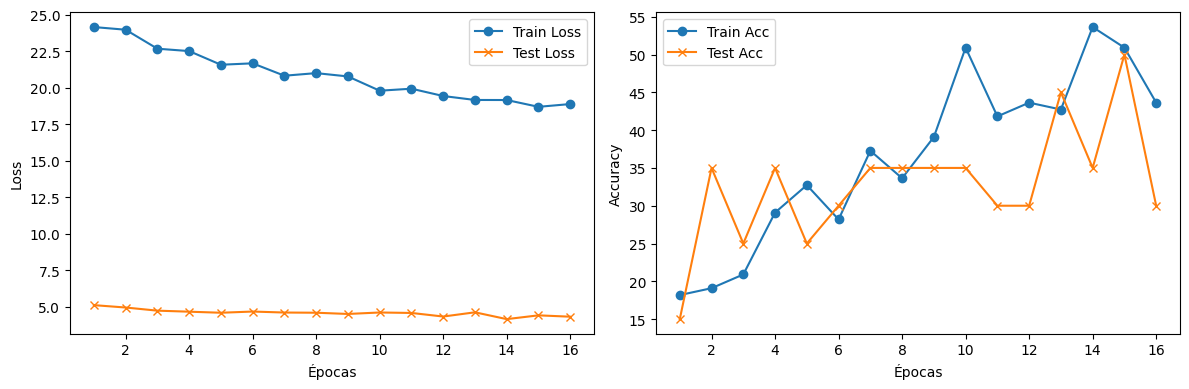

In [ ]:
epochs = list(range(1, 16 + 1))


plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(epochs, all_train_losses, label='Train Loss', marker='o')
plt.plot(epochs, all_test_losses, label='Test Loss', marker='x')
plt.xlabel('Épocas')
plt.ylabel('Loss')
plt.legend()


plt.subplot(1, 2, 2)
plt.plot(epochs, all_train_acc, label='Train Acc', marker='o')
plt.plot(epochs, all_test_acc, label='Test Acc', marker='x')
plt.xlabel('Épocas')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()